In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from tqdm import tqdm

from torchmetrics.classification import MulticlassF1Score, MulticlassAccuracy, ConfusionMatrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010)),
])

In [3]:
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print(len(train_dataset))
print(len(test_dataset))

50000
10000


In [5]:
train_dataset, val_dataset = random_split(train_dataset, [45000, 5000])

In [6]:
train = DataLoader(train_dataset, batch_size=64, shuffle=True)
val = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [7]:
class_names = train_dataset.dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Some instance of images

In [58]:
instance = transforms.Compose({
    transforms.ToTensor()
})

In [59]:
for_instance_dataset = datasets.CIFAR10('/data', train=True, download=True, transform=instance)

Files already downloaded and verified


In [60]:
for_instance = DataLoader(for_instance_dataset, batch_size=64, shuffle=True)

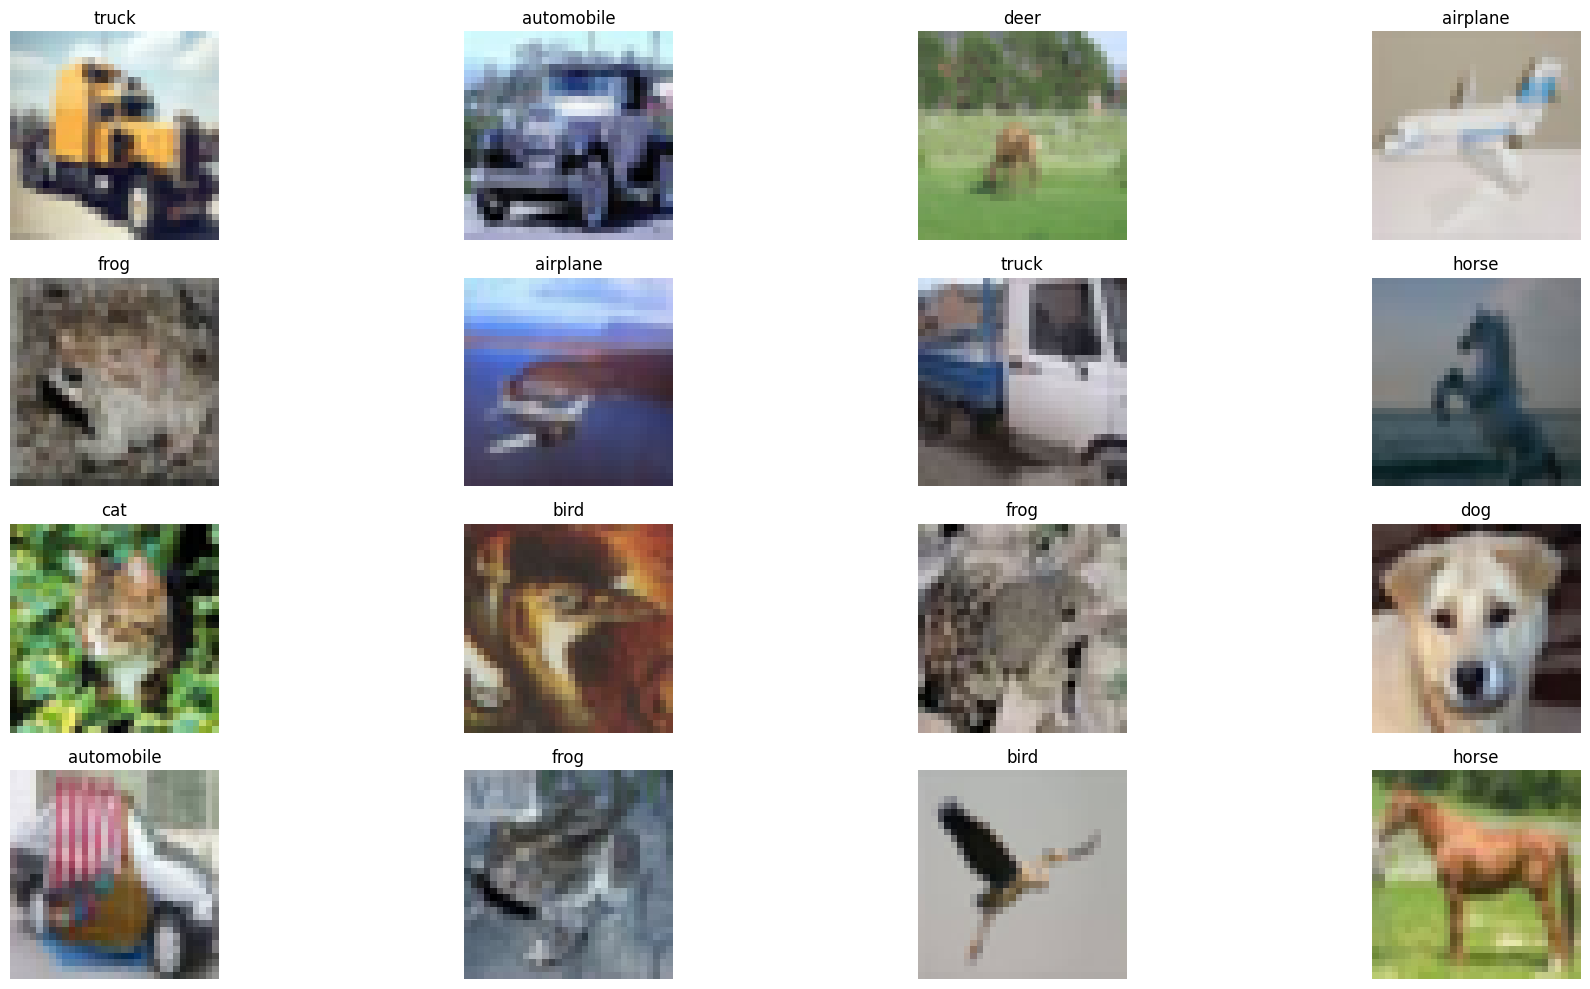

In [62]:
images, labels = next(iter(for_instance))

plt.figure(figsize=(20, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = images[i].permute(1, 2, 0)
    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis('off')

plt.tight_layout()
plt.show()


### Model

In [16]:
class CNNModel(nn.Module) :
    def __init__(self):
        super().__init__()
        
        self.CNN_layer = nn.Sequential(
            # 3 -> 64
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # 64 -> 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.2),

            # 128 -> 256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.3)

        )

        self.FC_layer = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )
    
    def forward(self, x) : 
        x = self.CNN_layer(x)
        x = self.FC_layer(x)
        return x

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)

### Train model

In [ ]:
f1 = MulticlassF1Score(num_classes=10, average='macro').to(device)
accuracy = MulticlassAccuracy(num_classes=10, average='macro').to(device)

best_f1 = 0
patience = 10
counter = 0


for epoch in range(100) :
    model.train()
    train_loss = 0

    loop_train = tqdm(train, desc=f"Epoch {epoch+1}/{100} [Training]", leave=False)
    for images, labels in loop_train :
        images, labels = images.to(device) , labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loop_train.set_postfix(loss=loss.item())
    
    model.eval()
    val_loss = 0

    with torch.no_grad() :
        loop_val = tqdm(val, desc=f"Epoch {epoch+1}/{100} [Validation]", leave=False)
        for images, labels in loop_val :
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            loop_val.set_postfix(loss=loss.item())

            f1.update(preds, labels)
            accuracy.update(preds, labels)


    current_f1 = f1.compute().item()
    current_acc = accuracy.compute().item()
    avg_train_loss = train_loss / len(train)
    avg_val_loss = val_loss / len(val)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train):.4f} | "
        f"Val Loss: {val_loss/len(val):.4f} | Val F1: {f1.compute():.4f} | Val Acc: {accuracy.compute():.4f}")
    
    f1.reset()
    accuracy.reset()

    if current_f1 > best_f1:
        best_f1 = current_f1
        counter = 0
        torch.save(model.state_dict(), "./Models/CNNModel.pth")
        print(f"Best model saved at epoch {epoch+1} with F1: {best_f1:.4f}")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs (patience: {patience})")

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best F1: {best_f1:.4f}")
        break

Epoch 1 | Train Loss: 1.7804 | Val Loss: 1.4597 | Val F1: 0.4050 | Val Acc: 0.4462
Best model saved at epoch 1 with F1: 0.4050


Epoch 2 | Train Loss: 1.4837 | Val Loss: 1.2784 | Val F1: 0.5182 | Val Acc: 0.5241
Best model saved at epoch 2 with F1: 0.5182


Epoch 3 | Train Loss: 1.3190 | Val Loss: 1.1012 | Val F1: 0.5933 | Val Acc: 0.5993
Best model saved at epoch 3 with F1: 0.5933


Epoch 4 | Train Loss: 1.2053 | Val Loss: 1.0745 | Val F1: 0.6220 | Val Acc: 0.6199
Best model saved at epoch 4 with F1: 0.6220


Epoch 5 | Train Loss: 1.1162 | Val Loss: 0.9377 | Val F1: 0.6497 | Val Acc: 0.6589
Best model saved at epoch 5 with F1: 0.6497


Epoch 6 | Train Loss: 1.0501 | Val Loss: 0.8686 | Val F1: 0.6906 | Val Acc: 0.6951
Best model saved at epoch 6 with F1: 0.6906


Epoch 7 | Train Loss: 0.9975 | Val Loss: 0.8269 | Val F1: 0.7102 | Val Acc: 0.7141
Best model saved at epoch 7 with F1: 0.7102


Epoch 8 | Train Loss: 0.9566 | Val Loss: 0.7556 | Val F1: 0.7264 | Val Acc: 0.7297
Best model saved at epoch 8 with F1: 0.7264


Epoch 9 | Train Loss: 0.9186 | Val Loss: 0.7694 | Val F1: 0.7338 | Val Acc: 0.7345
Best model saved at epoch 9 with F1: 0.7338


Epoch 10 | Train Loss: 0.8894 | Val Loss: 0.7504 | Val F1: 0.7455 | Val Acc: 0.7410
Best model saved at epoch 10 with F1: 0.7455


Epoch 11 | Train Loss: 0.8624 | Val Loss: 0.7301 | Val F1: 0.7514 | Val Acc: 0.7550
Best model saved at epoch 11 with F1: 0.7514


Epoch 12 | Train Loss: 0.8448 | Val Loss: 0.7446 | Val F1: 0.7554 | Val Acc: 0.7519
Best model saved at epoch 12 with F1: 0.7554


Epoch 13 | Train Loss: 0.8254 | Val Loss: 0.7664 | Val F1: 0.7385 | Val Acc: 0.7346
No improvement for 1 epochs (patience: 10)


Epoch 14 | Train Loss: 0.8125 | Val Loss: 0.7069 | Val F1: 0.7615 | Val Acc: 0.7607
Best model saved at epoch 14 with F1: 0.7615


Epoch 15 | Train Loss: 0.8009 | Val Loss: 0.7960 | Val F1: 0.7358 | Val Acc: 0.7323
No improvement for 1 epochs (patience: 10)


Epoch 16 | Train Loss: 0.7876 | Val Loss: 0.6921 | Val F1: 0.7659 | Val Acc: 0.7664
Best model saved at epoch 16 with F1: 0.7659


Epoch 17 | Train Loss: 0.7692 | Val Loss: 0.6188 | Val F1: 0.7915 | Val Acc: 0.7903
Best model saved at epoch 17 with F1: 0.7915


Epoch 18 | Train Loss: 0.7645 | Val Loss: 0.6164 | Val F1: 0.7889 | Val Acc: 0.7902
No improvement for 1 epochs (patience: 10)


Epoch 19 | Train Loss: 0.7534 | Val Loss: 0.5992 | Val F1: 0.7939 | Val Acc: 0.7932
Best model saved at epoch 19 with F1: 0.7939


Epoch 20 | Train Loss: 0.7543 | Val Loss: 0.5864 | Val F1: 0.7981 | Val Acc: 0.7964
Best model saved at epoch 20 with F1: 0.7981


Epoch 21 | Train Loss: 0.7345 | Val Loss: 0.5887 | Val F1: 0.8001 | Val Acc: 0.8016
Best model saved at epoch 21 with F1: 0.8001


Epoch 22 | Train Loss: 0.7436 | Val Loss: 0.5619 | Val F1: 0.8127 | Val Acc: 0.8114
Best model saved at epoch 22 with F1: 0.8127


Epoch 23 | Train Loss: 0.7268 | Val Loss: 0.5829 | Val F1: 0.7981 | Val Acc: 0.8008
No improvement for 1 epochs (patience: 10)


Epoch 24 | Train Loss: 0.7275 | Val Loss: 0.6500 | Val F1: 0.7863 | Val Acc: 0.7856
No improvement for 2 epochs (patience: 10)


Epoch 25 | Train Loss: 0.7155 | Val Loss: 0.6025 | Val F1: 0.8045 | Val Acc: 0.8030
No improvement for 3 epochs (patience: 10)


Epoch 26 | Train Loss: 0.7158 | Val Loss: 0.6600 | Val F1: 0.7842 | Val Acc: 0.7868
No improvement for 4 epochs (patience: 10)


Epoch 27 | Train Loss: 0.7103 | Val Loss: 0.5544 | Val F1: 0.8127 | Val Acc: 0.8113
No improvement for 5 epochs (patience: 10)


Epoch 28 | Train Loss: 0.7050 | Val Loss: 0.6102 | Val F1: 0.7942 | Val Acc: 0.7898
No improvement for 6 epochs (patience: 10)


Epoch 29 | Train Loss: 0.7073 | Val Loss: 0.5839 | Val F1: 0.8039 | Val Acc: 0.8026
No improvement for 7 epochs (patience: 10)


Epoch 30 | Train Loss: 0.6948 | Val Loss: 0.5852 | Val F1: 0.8006 | Val Acc: 0.8023
No improvement for 8 epochs (patience: 10)


Epoch 31 | Train Loss: 0.6974 | Val Loss: 0.5312 | Val F1: 0.8167 | Val Acc: 0.8162
Best model saved at epoch 31 with F1: 0.8167


Epoch 32 | Train Loss: 0.7009 | Val Loss: 0.6045 | Val F1: 0.8047 | Val Acc: 0.8003
No improvement for 1 epochs (patience: 10)


Epoch 33 | Train Loss: 0.6919 | Val Loss: 0.5129 | Val F1: 0.8225 | Val Acc: 0.8230
Best model saved at epoch 33 with F1: 0.8225


Epoch 34 | Train Loss: 0.6965 | Val Loss: 0.5410 | Val F1: 0.8179 | Val Acc: 0.8174
No improvement for 1 epochs (patience: 10)


Epoch 35 | Train Loss: 0.6825 | Val Loss: 0.5308 | Val F1: 0.8060 | Val Acc: 0.8080
No improvement for 2 epochs (patience: 10)


Epoch 36 | Train Loss: 0.6840 | Val Loss: 0.5629 | Val F1: 0.8083 | Val Acc: 0.8056
No improvement for 3 epochs (patience: 10)


Epoch 37 | Train Loss: 0.6775 | Val Loss: 0.5558 | Val F1: 0.8132 | Val Acc: 0.8129
No improvement for 4 epochs (patience: 10)


Epoch 38 | Train Loss: 0.6834 | Val Loss: 0.5226 | Val F1: 0.8303 | Val Acc: 0.8297
Best model saved at epoch 38 with F1: 0.8303


Epoch 39 | Train Loss: 0.6771 | Val Loss: 0.5636 | Val F1: 0.8139 | Val Acc: 0.8115
No improvement for 1 epochs (patience: 10)


Epoch 40 | Train Loss: 0.6689 | Val Loss: 0.6096 | Val F1: 0.7833 | Val Acc: 0.7854
No improvement for 2 epochs (patience: 10)


Epoch 41 | Train Loss: 0.6725 | Val Loss: 0.5217 | Val F1: 0.8277 | Val Acc: 0.8264
No improvement for 3 epochs (patience: 10)


Epoch 42 | Train Loss: 0.6720 | Val Loss: 0.5095 | Val F1: 0.8232 | Val Acc: 0.8226
No improvement for 4 epochs (patience: 10)


Epoch 43 | Train Loss: 0.6682 | Val Loss: 0.5734 | Val F1: 0.8104 | Val Acc: 0.8080
No improvement for 5 epochs (patience: 10)


Epoch 44 | Train Loss: 0.6733 | Val Loss: 0.5461 | Val F1: 0.8131 | Val Acc: 0.8146
No improvement for 6 epochs (patience: 10)


Epoch 45 | Train Loss: 0.6690 | Val Loss: 0.5770 | Val F1: 0.8041 | Val Acc: 0.8041
No improvement for 7 epochs (patience: 10)


Epoch 46 | Train Loss: 0.6639 | Val Loss: 0.5511 | Val F1: 0.8148 | Val Acc: 0.8158
No improvement for 8 epochs (patience: 10)


Epoch 47 | Train Loss: 0.6580 | Val Loss: 0.5382 | Val F1: 0.8139 | Val Acc: 0.8141
No improvement for 9 epochs (patience: 10)


Epoch 48 | Train Loss: 0.6630 | Val Loss: 0.5521 | Val F1: 0.8102 | Val Acc: 0.8083
No improvement for 10 epochs (patience: 10)
Early stopping at epoch 48. Best F1: 0.8303


### Load best Model

In [ ]:
model.load_state_dict(torch.load("./Models/CNNModel.pth"))

C:\Users\Legion\AppData\Local\Temp\ipykernel_17260\291327145.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CNNModel.pth"))


<All keys matched successfully>

### Test verification

In [13]:
def creat_heatmap(confusion_matrix) :
    plt.figure(figsize=(12, 7))
    sns.heatmap(confusion_matrix.compute().to('cpu'),
                annot=True, 
                fmt='d', 
                cmap='Blues', 
                linewidths=0.5, 
                square=True, 
                cbar_kws={"shrink": 0.75},
                xticklabels=class_names,
                yticklabels=class_names
    )


    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

Test Accuracy:0.7392 | Test F1:0.7410


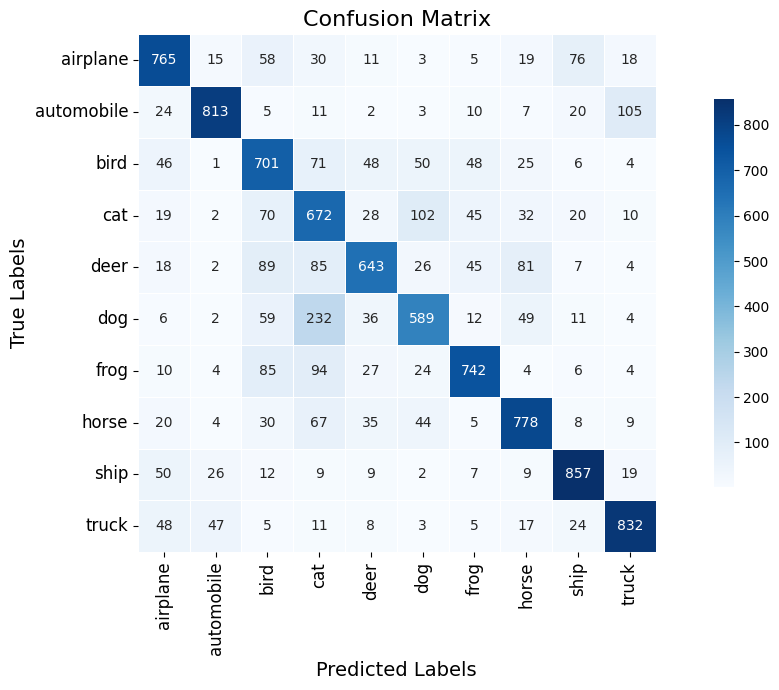

In [23]:
with torch.no_grad() :
    f1_test = MulticlassF1Score(num_classes=10, average='macro').to(device)
    accuracy_test = MulticlassAccuracy(num_classes=10, average='macro').to(device)
    CF = ConfusionMatrix(task='multiclass', num_classes=10).to(device)

    with torch.no_grad() :
        for images, labels in test :
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            f1_test.update(output, labels)
            accuracy_test.update(output, labels)
            CF.update(output, labels)

    print(f"Test Accuracy:{accuracy_test.compute():.4f} | Test F1:{f1_test.compute():.4f}")
    creat_heatmap(CF)

- Still can be improved

### New Model structure

In [8]:
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            # 3 -> 64
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # 64 -> 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # 128 -> 2256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Dropout2d(0.4)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Improvedmodel = ImprovedCNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(Improvedmodel.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [ ]:
f1 = MulticlassF1Score(num_classes=10, average='macro').to(device)
accuracy = MulticlassAccuracy(num_classes=10, average='macro').to(device)

best_f1 = 0
patience = 10
counter = 0


for epoch in range(100) :
    Improvedmodel.train()
    train_loss = 0

    loop_train = tqdm(train, desc=f"Epoch {epoch+1}/{100} [Training]", leave=False)
    for images, labels in loop_train :
        images, labels = images.to(device) , labels.to(device)
        optimizer.zero_grad()
        outputs = Improvedmodel(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loop_train.set_postfix(loss=loss.item())
    
    Improvedmodel.eval()
    val_loss = 0

    with torch.no_grad() :
        loop_val = tqdm(val, desc=f"Epoch {epoch+1}/{100} [Validation]", leave=False)
        for images, labels in loop_val :
            images, labels = images.to(device), labels.to(device)
            outputs = Improvedmodel(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            loop_val.set_postfix(loss=loss.item())

            f1.update(preds, labels)
            accuracy.update(preds, labels)


    current_f1 = f1.compute().item()
    current_acc = accuracy.compute().item()
    avg_train_loss = train_loss / len(train)
    avg_val_loss = val_loss / len(val)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train):.4f} | "
        f"Val Loss: {val_loss/len(val):.4f} | Val F1: {f1.compute():.4f} | Val Acc: {accuracy.compute():.4f}")
    
    f1.reset()
    accuracy.reset()

    if current_f1 > best_f1:
        best_f1 = current_f1
        counter = 0
        torch.save(Improvedmodel.state_dict(), "./Models/ImporovedCNNModel.pth")
        print(f"Best model saved at epoch {epoch+1} with F1: {best_f1:.4f}")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs (patience: {patience})")

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best F1: {best_f1:.4f}")
        break
    
    scheduler.step()

Epoch 1 | Train Loss: 2.0157 | Val Loss: 1.8126 | Val F1: 0.2232 | Val Acc: 0.2876
Best model saved at epoch 1 with F1: 0.2232


Epoch 2 | Train Loss: 1.6938 | Val Loss: 1.7745 | Val F1: 0.3066 | Val Acc: 0.3327
Best model saved at epoch 2 with F1: 0.3066


Epoch 3 | Train Loss: 1.4063 | Val Loss: 1.3536 | Val F1: 0.4971 | Val Acc: 0.5180
Best model saved at epoch 3 with F1: 0.4971


Epoch 4 | Train Loss: 1.1986 | Val Loss: 1.1760 | Val F1: 0.5825 | Val Acc: 0.5923
Best model saved at epoch 4 with F1: 0.5825


Epoch 5 | Train Loss: 1.0568 | Val Loss: 1.0035 | Val F1: 0.6351 | Val Acc: 0.6443
Best model saved at epoch 5 with F1: 0.6351


Epoch 6 | Train Loss: 0.9590 | Val Loss: 0.9519 | Val F1: 0.6711 | Val Acc: 0.6684
Best model saved at epoch 6 with F1: 0.6711


Epoch 7 | Train Loss: 0.8745 | Val Loss: 0.7462 | Val F1: 0.7441 | Val Acc: 0.7457
Best model saved at epoch 7 with F1: 0.7441


Epoch 8 | Train Loss: 0.8190 | Val Loss: 0.7452 | Val F1: 0.7569 | Val Acc: 0.7568
Best model saved at epoch 8 with F1: 0.7569


Epoch 9 | Train Loss: 0.7593 | Val Loss: 0.8264 | Val F1: 0.7330 | Val Acc: 0.7417
No improvement for 1 epochs (patience: 10)


Epoch 10 | Train Loss: 0.7118 | Val Loss: 0.6582 | Val F1: 0.7871 | Val Acc: 0.7876
Best model saved at epoch 10 with F1: 0.7871


Epoch 11 | Train Loss: 0.6933 | Val Loss: 0.6350 | Val F1: 0.7880 | Val Acc: 0.7881
Best model saved at epoch 11 with F1: 0.7880


Epoch 12 | Train Loss: 0.6620 | Val Loss: 0.6177 | Val F1: 0.7997 | Val Acc: 0.7989
Best model saved at epoch 12 with F1: 0.7997


Epoch 13 | Train Loss: 0.6356 | Val Loss: 0.5562 | Val F1: 0.8130 | Val Acc: 0.8143
Best model saved at epoch 13 with F1: 0.8130


Epoch 14 | Train Loss: 0.6076 | Val Loss: 0.6027 | Val F1: 0.7876 | Val Acc: 0.7903
No improvement for 1 epochs (patience: 10)


Epoch 15 | Train Loss: 0.6063 | Val Loss: 0.5725 | Val F1: 0.8081 | Val Acc: 0.8051
No improvement for 2 epochs (patience: 10)


Epoch 16 | Train Loss: 0.5894 | Val Loss: 0.6296 | Val F1: 0.7901 | Val Acc: 0.7922
No improvement for 3 epochs (patience: 10)


Epoch 17 | Train Loss: 0.5683 | Val Loss: 0.5653 | Val F1: 0.8119 | Val Acc: 0.8123
No improvement for 4 epochs (patience: 10)


Epoch 18 | Train Loss: 0.5579 | Val Loss: 0.5557 | Val F1: 0.8148 | Val Acc: 0.8138
Best model saved at epoch 18 with F1: 0.8148


Epoch 19 | Train Loss: 0.5539 | Val Loss: 0.5343 | Val F1: 0.8258 | Val Acc: 0.8235
Best model saved at epoch 19 with F1: 0.8258


Epoch 20 | Train Loss: 0.5384 | Val Loss: 0.6053 | Val F1: 0.8003 | Val Acc: 0.8009
No improvement for 1 epochs (patience: 10)


Epoch 21 | Train Loss: 0.4264 | Val Loss: 0.4248 | Val F1: 0.8599 | Val Acc: 0.8601
Best model saved at epoch 21 with F1: 0.8599


Epoch 22 | Train Loss: 0.4023 | Val Loss: 0.4263 | Val F1: 0.8576 | Val Acc: 0.8586
No improvement for 1 epochs (patience: 10)


Epoch 23 | Train Loss: 0.3869 | Val Loss: 0.4016 | Val F1: 0.8641 | Val Acc: 0.8650
Best model saved at epoch 23 with F1: 0.8641


Epoch 24 | Train Loss: 0.3763 | Val Loss: 0.3846 | Val F1: 0.8752 | Val Acc: 0.8770
Best model saved at epoch 24 with F1: 0.8752


Epoch 25 | Train Loss: 0.3673 | Val Loss: 0.4294 | Val F1: 0.8603 | Val Acc: 0.8585
No improvement for 1 epochs (patience: 10)


Epoch 26 | Train Loss: 0.3541 | Val Loss: 0.4371 | Val F1: 0.8579 | Val Acc: 0.8581
No improvement for 2 epochs (patience: 10)


Epoch 27 | Train Loss: 0.3566 | Val Loss: 0.4484 | Val F1: 0.8571 | Val Acc: 0.8581
No improvement for 3 epochs (patience: 10)


Epoch 28 | Train Loss: 0.3494 | Val Loss: 0.4168 | Val F1: 0.8589 | Val Acc: 0.8610
No improvement for 4 epochs (patience: 10)


Epoch 29 | Train Loss: 0.3410 | Val Loss: 0.4451 | Val F1: 0.8615 | Val Acc: 0.8628
No improvement for 5 epochs (patience: 10)


Epoch 30 | Train Loss: 0.3327 | Val Loss: 0.4259 | Val F1: 0.8576 | Val Acc: 0.8604
No improvement for 6 epochs (patience: 10)


Epoch 31 | Train Loss: 0.3288 | Val Loss: 0.4372 | Val F1: 0.8655 | Val Acc: 0.8653
No improvement for 7 epochs (patience: 10)


Epoch 32 | Train Loss: 0.3275 | Val Loss: 0.4901 | Val F1: 0.8445 | Val Acc: 0.8450
No improvement for 8 epochs (patience: 10)


Epoch 33 | Train Loss: 0.3279 | Val Loss: 0.3825 | Val F1: 0.8758 | Val Acc: 0.8762
Best model saved at epoch 33 with F1: 0.8758


Epoch 34 | Train Loss: 0.3196 | Val Loss: 0.4339 | Val F1: 0.8651 | Val Acc: 0.8671
No improvement for 1 epochs (patience: 10)


Epoch 35 | Train Loss: 0.3178 | Val Loss: 0.4068 | Val F1: 0.8726 | Val Acc: 0.8728
No improvement for 2 epochs (patience: 10)


Epoch 36 | Train Loss: 0.3167 | Val Loss: 0.4870 | Val F1: 0.8466 | Val Acc: 0.8478
No improvement for 3 epochs (patience: 10)


Epoch 37 | Train Loss: 0.3195 | Val Loss: 0.4011 | Val F1: 0.8691 | Val Acc: 0.8701
No improvement for 4 epochs (patience: 10)


Epoch 38 | Train Loss: 0.3133 | Val Loss: 0.4652 | Val F1: 0.8550 | Val Acc: 0.8535
No improvement for 5 epochs (patience: 10)


Epoch 39 | Train Loss: 0.3068 | Val Loss: 0.4980 | Val F1: 0.8525 | Val Acc: 0.8499
No improvement for 6 epochs (patience: 10)


Epoch 40 | Train Loss: 0.3148 | Val Loss: 0.4618 | Val F1: 0.8588 | Val Acc: 0.8606
No improvement for 7 epochs (patience: 10)


Epoch 41 | Train Loss: 0.2325 | Val Loss: 0.3735 | Val F1: 0.8883 | Val Acc: 0.8869
Best model saved at epoch 41 with F1: 0.8883


Epoch 42 | Train Loss: 0.2185 | Val Loss: 0.3585 | Val F1: 0.8894 | Val Acc: 0.8890
Best model saved at epoch 42 with F1: 0.8894


Epoch 43 | Train Loss: 0.2109 | Val Loss: 0.3559 | Val F1: 0.8906 | Val Acc: 0.8905
Best model saved at epoch 43 with F1: 0.8906


Epoch 44 | Train Loss: 0.2028 | Val Loss: 0.3909 | Val F1: 0.8821 | Val Acc: 0.8828
No improvement for 1 epochs (patience: 10)


Epoch 45 | Train Loss: 0.2014 | Val Loss: 0.3614 | Val F1: 0.8906 | Val Acc: 0.8907
Best model saved at epoch 45 with F1: 0.8906


Epoch 46 | Train Loss: 0.1977 | Val Loss: 0.3503 | Val F1: 0.8951 | Val Acc: 0.8948
Best model saved at epoch 46 with F1: 0.8951


Epoch 47 | Train Loss: 0.1942 | Val Loss: 0.3907 | Val F1: 0.8798 | Val Acc: 0.8819
No improvement for 1 epochs (patience: 10)


Epoch 48 | Train Loss: 0.1894 | Val Loss: 0.4045 | Val F1: 0.8781 | Val Acc: 0.8793
No improvement for 2 epochs (patience: 10)


Epoch 49 | Train Loss: 0.1855 | Val Loss: 0.3689 | Val F1: 0.8928 | Val Acc: 0.8932
No improvement for 3 epochs (patience: 10)


Epoch 50 | Train Loss: 0.1846 | Val Loss: 0.3619 | Val F1: 0.8930 | Val Acc: 0.8932
No improvement for 4 epochs (patience: 10)


Epoch 51 | Train Loss: 0.1892 | Val Loss: 0.3625 | Val F1: 0.8928 | Val Acc: 0.8935
No improvement for 5 epochs (patience: 10)


Epoch 52 | Train Loss: 0.1813 | Val Loss: 0.3704 | Val F1: 0.8899 | Val Acc: 0.8912
No improvement for 6 epochs (patience: 10)


Epoch 53 | Train Loss: 0.1881 | Val Loss: 0.3871 | Val F1: 0.8859 | Val Acc: 0.8860
No improvement for 7 epochs (patience: 10)


Epoch 54 | Train Loss: 0.1808 | Val Loss: 0.3755 | Val F1: 0.8872 | Val Acc: 0.8862
No improvement for 8 epochs (patience: 10)


Epoch 55 | Train Loss: 0.1789 | Val Loss: 0.3746 | Val F1: 0.8903 | Val Acc: 0.8907
No improvement for 9 epochs (patience: 10)


Epoch 56 | Train Loss: 0.1733 | Val Loss: 0.3710 | Val F1: 0.8910 | Val Acc: 0.8902
No improvement for 10 epochs (patience: 10)
Early stopping at epoch 56. Best F1: 0.8951


### Load model

In [11]:
Improvedmodel.load_state_dict(torch.load("./Models/ImporovedCNNModel.pth"))

C:\Users\Legion\AppData\Local\Temp\ipykernel_23024\2589168535.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Improvedmodel.load_state_dict(torch.load("./Models/Imporove

<All keys matched successfully>

### New model test validation

Test Accuracy:0.8653 | Test F1:0.8645


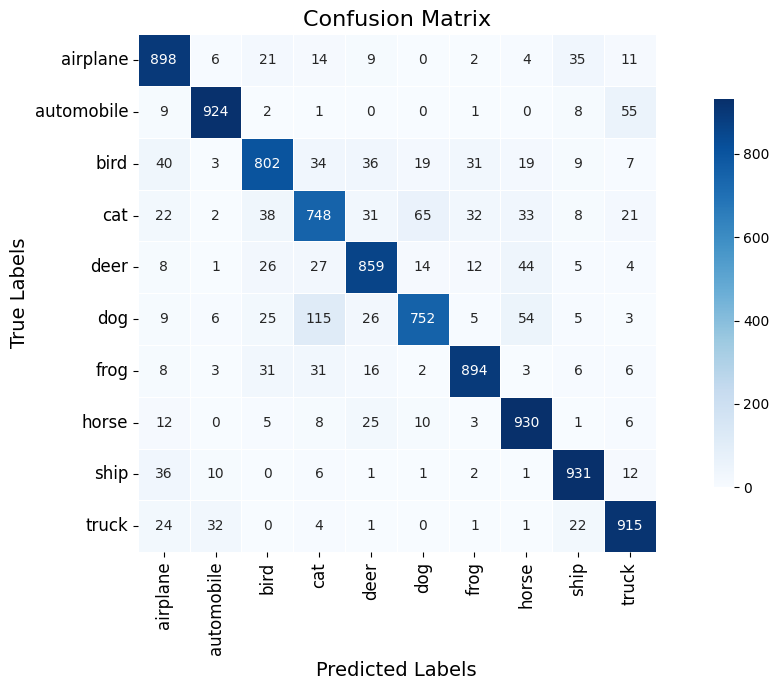

In [15]:
f1_test = MulticlassF1Score(num_classes=10, average='macro').to(device)
accuracy_test = MulticlassAccuracy(num_classes=10, average='macro').to(device)
CF = ConfusionMatrix(task='multiclass', num_classes=10).to(device)

with torch.no_grad() :
    for images, labels in test :
        images, labels = images.to(device), labels.to(device)
        output = Improvedmodel(images)
        f1_test.update(output, labels)
        accuracy_test.update(output, labels)
        CF.update(output, labels)

print(f"Test Accuracy:{accuracy_test.compute():.4f} | Test F1:{f1_test.compute():.4f}")
creat_heatmap(CF)

- Get significantly better

# 📊 Training Summary

### Selected Epoch Results

| Epoch | Train Loss | Val Loss | Val F1  | Val Acc | Note                   |
|-------|------------|----------|---------|---------|------------------------|
| 1     | 2.0157     | 1.8126   | 0.2232  | 0.2876  | Initial performance    |
| 3     | 1.4063     | 1.3536   | 0.4971  | 0.5180  | First significant gain |
| 6     | 0.9590     | 0.9519   | 0.6711  | 0.6684  |                        |
| 10    | 0.7118     | 0.6582   | 0.7871  | 0.7876  |                        |
| 13    | 0.6356     | 0.5562   | 0.8130  | 0.8143  |                        |
| 19    | 0.5539     | 0.5343   | 0.8258  | 0.8235  |                        |
| 24    | 0.3763     | 0.3846   | 0.8752  | 0.8770  | Peak mid-performance   |
| 33    | 0.3279     | 0.3825   | 0.8758  | 0.8762  |                        |
| 41    | 0.2325     | 0.3735   | 0.8883  | 0.8869  |                        |
| 43    | 0.2109     | 0.3559   | 0.8906  | 0.8905  |                        |
| 46    | 0.1977     | 0.3503   | 0.8951  | 0.8948  | ✅ Best model saved     |
| 56    | 0.1733     | 0.3710   | 0.8910  | 0.8902  | 🛑 Early stopping      |

---

### ✅ Final Test Results

- **Test Accuracy**: `0.8653`
- **Test F1 Score**: `0.8645`
